<h1><center> Projeto Final<center></h1>
<h1><center>Toxic Comment Classification Challenge<center></h1>

Esse notebook descreve o processo de pré-processamento dos dados, construção, treino e teste de modelos de classificação e comparação dos resultados entre os modelos testados para uma versão adaptada do challenge "Toxic Comment Classification", disponível em https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview.

## Preparando o ambiente do notebook

In [1]:
# manipulação dos dados
import numpy as np

import pandas as pd

import pickle


# treino e teste dos modelos utilizados
import sklearn

from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import KFold

from sklearn.feature_extraction.text import CountVectorizer

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation

from keras.layers import Bidirectional, GlobalMaxPool1D

from keras.models import Model

from keras import initializers, regularizers, constraints, optimizers, layers

from keras.callbacks import LearningRateScheduler

import tensorflow as tf

# gráficos e visualização dos dados em geral
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns

# limpeza dos dados
from langdetect import DetectorFactory, detect
from langdetect.lang_detect_exception import LangDetectException
DetectorFactory.seed = 0

import string

import re

from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences

from gensim.parsing.preprocessing import remove_stopwords

## Lendo o arquivo e visualizando os dados

In [2]:
# lê o dataset de treino
train = pd.read_csv('data/train.csv')

# lê os comentários do dataset de test
test_comments = pd.read_csv('data/test.csv')

# lê os valores esperados de output do modelo
test_labels = pd.read_csv('data/test_labels.csv')

# merge os datasets ao longo da coluna id
test = test_comments.merge(test_labels, on='id')

# exclui as entradas com valor [-1,-1,-1,-1,-1,-1]
mask = test[test['toxic'] == -1].index
mask
test.drop(mask, axis=0, inplace=True)

# torna a classificação binária ao invés de categórica
train.drop(train[['severe_toxic','obscene','threat','insult','identity_hate']], axis = 1, inplace = True)
test.drop(test[['severe_toxic','obscene','threat','insult','identity_hate']], axis = 1, inplace = True)

train.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [3]:
train.info

<bound method DataFrame.info of                       id                                       comment_text  \
0       0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1       000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2       000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3       0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4       0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   
...                  ...                                                ...   
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        toxic  
0  

Analisando a distribuição dos dados, vemos que a classificação é binária e que aproximadamente 90% dos dados pertence a uma das categorias.

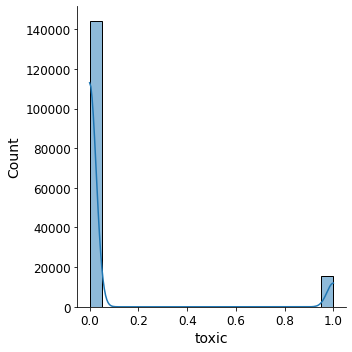

In [4]:
sns.displot(data = train, x = "toxic", kde=True)

In [5]:
test.head()

,id,comment_text,toxic
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0
7,000247e83dcc1211,:Dear god this site is horrible.,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0


## Limpando os dados

Antes de começarmos o processo de tokenização do texto e word embedding em si, vamos garantir que os comentários:
- não tenham valores nulos
- estejam todos em letras minúsculas
- não contenham números ou símbolos que atrapalhem o processo de tokenização ou o treinamento do modelo
- não contenham texto considerado sem sentido (ex: '\n')
- estejam todos em inglês

Verificando se há valores nulos em algum dos datasets

In [6]:
train.isnull().any(),test.isnull().any()

(id              False
 comment_text    False
 toxic           False
 dtype: bool,
 id              False
 comment_text    False
 toxic           False
 dtype: bool)

Como não há valores nulos nos dados, podemos prosseguir limpando outros atributos nas entradas

In [7]:
train

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0


In [8]:
def clean_text_1(text):
    
    #converte o texto para letras minúsculas
    text = text.lower()
    
    # remove sinais de pontuação do texto
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    #remove dígitos do texto
    text = re.sub('\d', '', text)
    
    return text

step1 = lambda x: clean_text_1(x)

def clean_text_2(text):
    
    #remove outros sinais de pontuação
    text = re.sub('[''""...]', '', text)
    
    # remove texto sem sentido
    text = re.sub('\n',' ', text)
    
    return text

step2 = lambda x: clean_text_2(x)

def language_check(text):
    
    is_english = True
    
    try:
       
    #checa se o texto está em inglês ou não
        if detect(text) != "en":
            is_english = False
            
    # trata erros como não inglês
    except LangDetectException:
        is_english = False
    if is_english == True:
        return text
    else:
        return np.nan
    
language = lambda x: language_check(x)

stop_words = lambda x: remove_stopwords(x)

In [9]:
train['comment_text'] = train['comment_text'].apply(step1)
test['comment_text'] = test['comment_text'].apply(step1)
train

,id,comment_text,toxic
0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0
3,0001b41b1c6bb37e,\nmore\ni cant make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0
...,...,...,...
159566,ffe987279560d7ff,and for the second time of asking when your vi...,0
159567,ffea4adeee384e90,you should be ashamed of yourself \n\nthat is ...,0
159568,ffee36eab5c267c9,spitzer \n\numm theres no actual article for p...,0
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0


In [10]:
train['comment_text'] = train['comment_text'].apply(step2)
test['comment_text'] = test['comment_text'].apply(step2)
train

,id,comment_text,toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0
3,0001b41b1c6bb37e,more i cant make any real suggestions on impr...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0
...,...,...,...
159566,ffe987279560d7ff,and for the second time of asking when your vi...,0
159567,ffea4adeee384e90,you should be ashamed of yourself that is a ...,0
159568,ffee36eab5c267c9,spitzer umm theres no actual article for pro...,0
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0


In [11]:
train['comment_text'] = train['comment_text'].apply(language)
test['comment_text'] = test['comment_text'].apply(language)


# remove as entradas que estavam em outras línguas
train.dropna(inplace=True)
test.dropna(inplace=True)

In [12]:
# remove palavras consideradas stopwords

train['comment_text'] = train['comment_text'].apply(remove_stopwords)
test['comment_text'] = test['comment_text'].apply(remove_stopwords)

In [13]:
test

,id,comment_text,toxic
5,0001ea8717f6de06,thank understanding think highly revert discus...,0
7,000247e83dcc1211,dear god site horrible,0
11,0002f87b16116a7f,somebody invariably try add religion mean way ...,0
13,0003e1cccfd5a40a,says right type type institution needed case l...,0
14,00059ace3e3e9a53,adding new product list sure relevant adding n...,0
...,...,...,...
153150,fff8f64043129fa2,jerome got this… i’m surprised looked example ...,0
153151,fff9d70fe0722906,lucky bastard httpwikimediafoundationorgwikipr...,0
153154,fffa8a11c4378854,shame want speak gays romanians,0
153155,fffac2a094c8e0e2,mel gibson nazi bitch makes shitty movies butt...,1


Testes com lematização e normalização dos dados não se mostraram significativamente melhores, sendo cortados desse notebook por esse motivo.

## Separando os dados em conjuntos X e y

Primeiro definimos nosso conjunto de resultados esperados tanto para o conjunto de treino quanto para o de teste:

In [14]:
y_train = train['toxic'].values
y_test = test['toxic'].values

Em seguida, definimos X como os dados a serem classificados, nesse caso os comentários:

In [15]:
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [16]:
list_sentences_test

5         thank understanding think highly revert discus...
7                                    dear god site horrible
11        somebody invariably try add religion mean way ...
13        says right type type institution needed case l...
14        adding new product list sure relevant adding n...
                                ...                        
153150    jerome got this… i’m surprised looked example ...
153151    lucky bastard httpwikimediafoundationorgwikipr...
153154                      shame want speak gays romanians
153155    mel gibson nazi bitch makes shitty movies butt...
153156    unicorn lair discovery supposedly unicorn lair...
Name: comment_text, Length: 59702, dtype: object

## Criando um corpus
Corpus nada mais é do que uma coleção textos, nesse caso, o conteúdo dos comentários que usaremos para treinar o modelo de classificação.

In [17]:
train['comment_text'].to_pickle('corpus1.pkl')

## Tokenização dos dados
Nesta etapa vamos:
- quebrar o texto dos comentários dos datasets de treino e de teste em palavras ou tokens
- criar uma estrutura similar a um dicionário indexando cada palavra nova que encontrarmos
- representar os  textos por meio de sequências numéricas em que cada número corresponde ao índice de uma palavra na estrutura que criamos

Usando a funções da biblioteca Keras.

In [18]:
# Definimos o número máximo de palavras a serem tokenizadas pelo Tokenizer e o instanciamos
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)

# Usando o método fit_on_texts(), atualizamos o vocabulário do Tokenizer
tokenizer.fit_on_texts(list(list_sentences_train))

# Usamos o Tokenizer com o vocabulário atualizado para converter o texto dos comentários em sequências numéricas
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

Mesmo após a tokenização dos nossos dados, ainda temos o problema do número de atributos. A fim de usarmos o modelo que temos em mente, precisamos que os comentários tenham o mesmo número de atributos (a fim de conseguirmos computar a dimensão do output da nossa camada dense mais à frente), ou palavras nesse caso. Para resolvermos esse problema, iremos usar uma técnica chamada "padding" em que preenchemos os comentários menores com zeros ou cortamos os comentários maiores para se adequarem aos menores.

Para acharmos o "número mágico" que utilizaremos para esse padding, vamos ver a frequência de distribuição dos comprimentos das palavras:

In [19]:
#cria uma lista com a quantidade de palavras em cada comentário
len_words = [len(comment) for comment in list_tokenized_train]

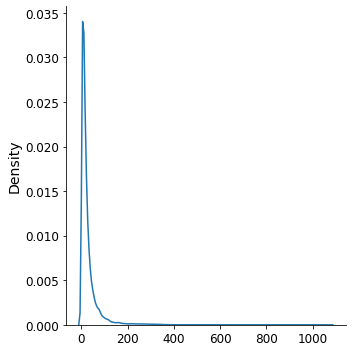

In [20]:
sns.displot(data=len_words, kind='kde')

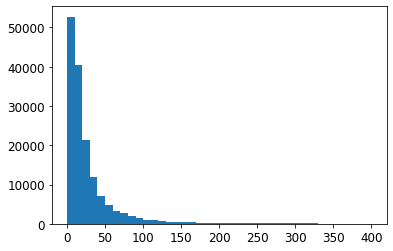

In [21]:
plt.hist(len_words,bins = np.arange(0,410,10))
plt.show()

In [22]:
# converte a lista em uma série da biblioteca Pandas
len_words_series = pd.Series(len_words)
# encontra o valor abaixo do qual se encontram 75% dos dados e progride de 10 em 10%
print(len_words_series.quantile(0.75))
print(len_words_series.quantile(0.85))
print(len_words_series.quantile(0.95))

31.0
46.0
94.0


Pelo histograma de frequência, percebemos que a maior parte dos dados se concentra na faixa de 0~50 palavras e pelo método .quantile() do pandas, vemos que 75% dos dados estão abaixo de 31 palavras, mas que esse número permanece razoavelmente pequeno até no percentil 95%, sendo assim, usaremos um maxlen de 100 palavras a fim de mantermos a maior quantidade de dados possíveis sem perda de eficiência.

In [23]:
# estabelece o número padrão de atributos
maxlen = 100

# usa a função pad_sequences da biblioteca Keras para padronizar o número de atributos nas entradas
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

## Construindo o modelo
Nesta etapa iremos:
- definir as camadas que usaremos no nosso modelo Long Short-Term Memory, fornecido pela API tensorflow
- definir as dimensões de cada camada

### Camada de input
Primeiramente, temos que definir nossa camada de input que receberá as listas de comentários codificados que criamos acima. Para isso, criamos uma camada de dimensão 100 (número de atributos de cada comentário que definimos acima) e deixamos o segundo parâmetro vazio para que o Keras infira o número de comentários automaticamente.

In [24]:
# criamos uma camada de input maxlen X (número de amostras)
inp = Input(shape =(maxlen, ))

### Camada de embedding
Após criarmos uma camada de input, partimos para nossa camada de embedding. Nessa camada, as palavras do nosso vocabulário são projetadas em um espaço vetorial de acordo com sua proximidade de outras palavras nos comentários, de modo que palavras similares sejam projetadas próximas umas das outras. Para isso, temos que definir a dimensão do nosso espaço vetorial (número de coordenadas que cada palavra terá quando projetada) e o número de palavras diferentes que usaremos (que definimos acima na tokenização dos comentários).

In [25]:
# definimos a dimensão do nosso espaço vetorial
embed_size = 128

# criamos a camada de embedding com 20000 palavras diferentes (máx) e espaço vetorial de dimensão 128 
# e a conectamos à camada de input
x = Embedding(max_features, embed_size)(inp)

Note que a camada de embedding retorna um tensor tridimensional (nro de amostras, 100, 128). composto por uma array de comentários e para cada palavra (100) há uma array de 128 coordenadas no espaço vetorial.

### Camada LSTM
Depois de definirmos nossa camada de embedding, vamos criar nossa camada classificadora usando o modelo longa memória de curto prazo, uma rede neural recursiva que recebe como input um tensor de dimensões (batch_size, timesteps, number_of_inputs) em que a primeira dimensão corresponde ao número de amostras, a segunda ao número de recursões que a rede neural fará e a terceira ao número de atributos associados a cada amostra. 

Usaremos como input o tensor que geramos na nossa camada de embedding, o que fará com que nossa rede neural tenha como input batch_size = nro de amostras, timesteps = 100, number_of_inputs = 128, ou seja, ela percorrerá a lista de comentários rodando 100 recursões do modelo LSTM usando como input as coordenadas das palavras atualizadas a cada recursão. A fim de melhorar a acurácia do nosso modelo, iremos manter o histórico das 60 últimas iterações para cada amostra definindo o parâmetro return_sequences como True.

In [26]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

### Camada de Pooling
Note que nossa camada LSTM nos retorna um tensor tridimensional (nro de amostras, 100, 60). Antes de podermos passar esse tensor às camadas seguintes, precisamos reduzir sua dimensionalidade. Para isso, usaremos uma camada de pooling que reduz nosso tensor tridimensional a duas dimensões pegando o maior valor sobre a dimensão tempo, transformando nosso tensor (batch_size, steps, features) em um tensor (batch_size, features).

In [27]:
x = GlobalMaxPool1D()(x)

### Camada de Dropout
Após reduzirmos a dimensionalidade do nosso tensor, passamos ele por uma camada de dropout em que alguns nós são "desativados" de maneira aleatória forçando a próxima camada a lidar com dados faltantes e, consequentemente, resultando em uma maior capacidade de generalização pela rede neural. Para esse exemplo, usaremos uma taxa de desativação de 10%, ou seja, aleatoriamente desativaremos 10% dos nós.

In [28]:
x = Dropout(0.1)(x)

### Camada densa
Após passarmos nosso tensor pela camada de drop out, usamos seu output como input para uma camada densamente conectada e definimos a ativação de seus nós através de uma função ReLu. Definiremos essa camada de forma que ela retorne um output de dimensão 50.

In [29]:
x = Dense(50, activation='relu')(x)

### Camada de Dropout
Passamos o output por outra camada de drop out a fim de uma melhor capacidade de generalização.

In [30]:
x = Dropout(0.1)(x)

### Camada Sigmoide
Por fim, passamos o output da camada de drop out final por uma camada sigmoide que normaliza o output entre 0 e 1, nos dando a classificação binária que desejamos. Definiremos a dimensão do output dessa camada como 1, de forma a obtermos o número que define a classificação do modelo entre tóxico e não tóxico, com 1 sendo definitivamente tóxico e 0 sendo definitivamente não tóxico. 

In [31]:
x = Dense(1, activation="sigmoid")(x)

## Compilando o modelo
Enfim, compilamos o nosso modelo usando nossa camada de input que definimos acima e os outputs como as camadas conectadas restantes. Usaremos a função binary_crossentropy da biblioteca Keras para calcularmos a perda e o otimizador adam, também da biblioteca Keras. Vamos usar uma taxa de aprendizado variável da forma Step Decay a fim de otimizar a performance do nosso modelo.

Definindo a função que nos dá a rotina da taxa de aprendizado e a inicializando:

In [32]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)

In [33]:
model = Model(inputs=inp, outputs=x)

opt = tf.keras.optimizers.Adam()

model.compile(loss='binary_crossentropy',
                  optimizer= opt,
                  metrics=['accuracy'])

## Testando o modelo
Partimos, então, para o teste da performance do nosso modelo usando uma lista de 32 comentários já pré-processados do nosso conjunto de teste como "batch" e separaremos 10% dos dados como nosso conjunto de validação. O conjunto de validação funcionará para determinar se nosso modelo está ou não cometendo overfitting para cada batch. O rodaremos por 3 epochs a fim de melhor aproveitar a função de taxa de aprendizado.

In [34]:
batch_size = 32
epochs = 3
model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[lr_sched])

Epoch 1/3
4352/4352 [==============================] - 282s 64ms/step - loss: 0.2146 - accuracy: 0.9278 - val_loss: 0.1208 - val_accuracy: 0.9552 - lr: 1.0000e-04
Epoch 2/3
4352/4352 [==============================] - 274s 63ms/step - loss: 0.1063 - accuracy: 0.9616 - val_loss: 0.1133 - val_accuracy: 0.9595 - lr: 1.0000e-04
Epoch 3/3
4352/4352 [==============================] - 269s 62ms/step - loss: 0.0907 - accuracy: 0.9665 - val_loss: 0.1133 - val_accuracy: 0.9602 - lr: 7.5000e-05


Testando o modelo com o set de teste usando a matriz de confusão como métrica:

In [35]:
# geramos as previsões para o conjunto de teste
predictions = model.predict(X_test)

In [36]:
# convertemos a array resultante em um DataFrame e plotamos sua distribuição abaixo
predictions_df = pd.DataFrame(predictions, columns =['predictions'])

Analisando a distribuição das previsões, definiremos um threshold entre 0.8 e 1, de forma a tentar tornar binária essa distribuição contínua classificando o máximo de exemplos corretamente.

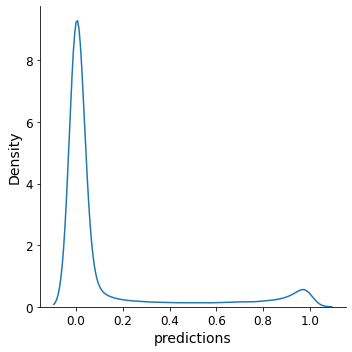

In [37]:
sns.displot(predictions_df, x='predictions', kind='kde')

In [38]:
# tornando os valores contínuos binários
threshold = 0.857                                 # threshold definido de forma a gerar uma matriz mais concentrada ao longo da
predictions_classes = np.zeros_like(predictions)  # diagonal principal
predictions_classes[predictions > threshold] = 1

matrix = confusion_matrix(y_test, predictions_classes)

matrix


array([[53092,  1170],
       [ 2406,  3034]], dtype=int64)

## Construindo o modelo parte 2
Bem, nas etapas acima construimos, treinamos e testamos um modelo LSTM fornecido pela API tensorflow que nos deu uma acurácia de 96,9% aproximadamente nos casos do set de treino e que foi observado pela matriz de confusão como sendo bastante capaz de classificar comentários tóxicos corretamente. No entanto, é interessante que comparemos os resultados do nosso modelo com os de outro modelo de arquitetura diferente, a fim de verificarmos qual tem maior eficiência, menor custo computacional e maior acurácia.

Para isso, iremos usar os mesmos dados de treino e de teste para construir um modelo de regressão logística e compararemos os resultados obtidos pelos dois modelos para determinarmos qual é o mais vantajoso.

### Adaptando o embedding
para nosso modelo LSTM, usamos uma camada de embedding, aqui usaremos um embedding bag of words que montaremos utilizando o modelo CountVectorizer da biblioteca sklearn.

In [39]:
cv = CountVectorizer()

X_train_logistic = cv.fit_transform(list_sentences_train)
X_test_logistic = cv.transform(list_sentences_test)

### instanciando o modelo:
Escolhido o modelo LogisticRegression da biblioteca sklearn para compararmos com o nosso modelo LSTM, iremos agora instanciá-lo e configurar seus parâmetros.

In [40]:
# intanciamos o modelo escolhido com diferentes solvers, definindo o parâmetro class_weight como balanced tendo em vista a
# proporção da distribuição dos textos por classe que observamos no início deste notebook
model2 = LogisticRegression(class_weight = 'balanced')
model3 = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')
model4 = LogisticRegression(solver = 'saga', class_weight = 'balanced')

# definimos o numero de folds
k = 5

# usamos o modelo Kfold do sklearn para dividir o conjunto de treino e teste em folds
kf = KFold(n_splits=k, random_state=None)


# geramos as acurácias através de uma cross-validation
result2 = cross_val_score(model2 , X_train_logistic, y_train, cv = kf)
result3 = cross_val_score(model3 , X_train_logistic, y_train, cv = kf)
result4 = cross_val_score(model4 , X_train_logistic, y_train, cv = kf)

c:\users\lucas\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\lucas\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

In [41]:
# comparamos as acurácias médias
print("Avg accuracy_2: {}".format(result2.mean()))
print("Avg accuracy_3: {}".format(result3.mean()))
print("Avg accuracy_4: {}".format(result4.mean()))

Avg accuracy_2: 0.9488624612202688
Avg accuracy_3: 0.947892967942089
Avg accuracy_4: 0.8516416752843847


Analisando as acurácias médias, vemos que, como esperado dado o tamanho do dataset, o solver lbfgs teve uma acurácia maior, sendo escolhido como parâmetro a ser usado no modelo que vamos comparar.

In [42]:
optimal_logistic = model2 
optimal_logistic.fit(X_train_logistic, y_train)
predictions_logistic = optimal_logistic.predict(X_test_logistic)

c:\users\lucas\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
predictions_logistic_df = pd.DataFrame(predictions_logistic, columns = ['predictions'])

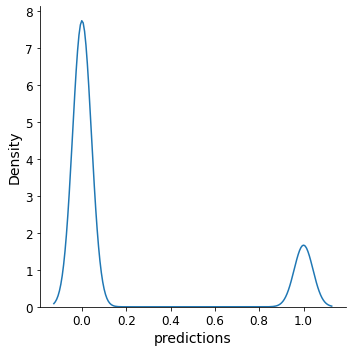

In [44]:
sns.displot(predictions_logistic_df, x='predictions', kind='kde')

In [45]:
# tornando os valores contínuos binários
# threshold definido de forma a gerar uma matriz mais concentrada ao longo da diagonal principal

threshold = 0.8
predictions_logistic_classes = np.zeros_like(predictions_logistic)
predictions_logistic_classes[predictions_logistic > threshold] = 1

matrix_logistic = confusion_matrix(y_test, predictions_logistic)
matrix_logistic

array([[48462,  5800],
       [  657,  4783]], dtype=int64)

## Comparando os Modelos e Conclusão
Por fim, compararemos as métricas dos modelos que construimos e testamos, perceba que o modelo LSTM do Tensorflow tem uma performance melhor, evidenciada pela comparação das matrizes de confusão, das distibuição das previsões e das acurácias. Porém, perceba também que enquanto os tempos de treino do modelo LSTM giraram em torno de 12 minutos para esse dataset, apresentando uso elevado da cpu e memória ram, e os de teste em torno 3 minutos, os tempos de treino do modelo de regressão logística giraram em torno de 2 minutos e os de teste em torno de 1 minuto, consumindo significativamente menos recursos computacionais. Em suma, como é observável um ganho de acurácia de apenas em torno de 2% de um modelo para o outro, é não é justificável o uso do modelo LSTM mais robusto para essa tarefa de classificação binária uma vez que os ganhos de acurácia e a diminuição de falsos positivos e de falsos negativos são marginais se comparados com o aumento do requisito de recursos computacionais.